In [56]:
from scipy.constants import pi 
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite
import plotly.graph_objects as go
from scipy.special import factorial


In [57]:
# Free parameters, typical setup for a HeNe laser (https://sites.astro.caltech.edu/~lah/ay105/pdf/Laser-Guide.pdf, page 8)

w_0 = 0.13 * 10**-3 # Beam waist (0.13 mm)
n = 1 # Refractive index of air
wavelength = 633 * 10**-9 # 633 nanometers (red light)
E_0 = 1 + 0j # E (V/m) some arbitrary value for visualization

k = 2 * pi * n / wavelength # Wave number

In [58]:
z_R = pi * w_0**2 * n / wavelength # Rayleigh range

def w(z):
    return w_0 * np.sqrt(1+ np.power(z/z_R, 2))

def R(z):
    # numerical stability at z=0
    if z == 0:
        return np.inf
    
    return z * (1 + (z_R/z)**2)


def E(x, y, z, l, m): # Returns a complex electric field value at (x,y,z) for mode (l,m)
    # Get Hermite polynomial functions for l and m
    H_l = hermite(l) 
    H_m = hermite(m)
    N = l+m
    
    u = np.sqrt(2) * x / w(z)
    v = np.sqrt(2) * y / w(z)
    
    norm_factor = np.sqrt(2 / (pi * 2**(l+m) * factorial(l) * factorial(m)))
    
    real = E_0 * norm_factor * (w_0/w(z)) * H_l(u) * H_m(v) * np.exp(-(x**2 + y**2)/(w(z)**2))
    
    radial_phase = -k *(x**2 + y**2)/(2*R(z))
    longitudal_phase = -k*z
    gouy_phase = (N + 1) * np.arctan(z/z_R)

    phase = radial_phase + longitudal_phase + gouy_phase
    
    return real * np.exp(1j * phase) # Complex electric field

In [59]:
def superposition(x, y, z, modes):
    E_total = 0
    for (l, m, coeff) in modes:
        E_total += coeff * E(x, y, z, l, m) # Linear superposition of modes, weighted by coeffients
    return E_total

In [60]:
z = 0
x = np.linspace(-3*w_0, 3*w_0, 400)
y = np.linspace(-3*w_0, 3*w_0, 400)
X, Y = np.meshgrid(x, y)

# Single TEM00 mode
modes_fun =  [
    (0, 0, 1.0),    # TEM00, base intensity
    (2, 0, 1.0),    # TEM20, adds horizontal lobes
    (0, 2, 1.0),    # TEM02, adds vertical lobes
    (1, 1, -1.5),   # TEM11, creates diagonal nodes
    (3, 0, 0.7),    # TEM30, more horizontal structure
    (0, 3, -0.7),   # TEM03, more vertical structure
    (2, 2, 1.2),    # TEM22, adds symmetric “petals”
    (1, 2, -0.8),   # TEM12, diagonal asymmetry
    (2, 1, 0.8)     # TEM21, diagonal asymmetry opposite
]
E_fun = superposition(X, Y, z, modes_fun)

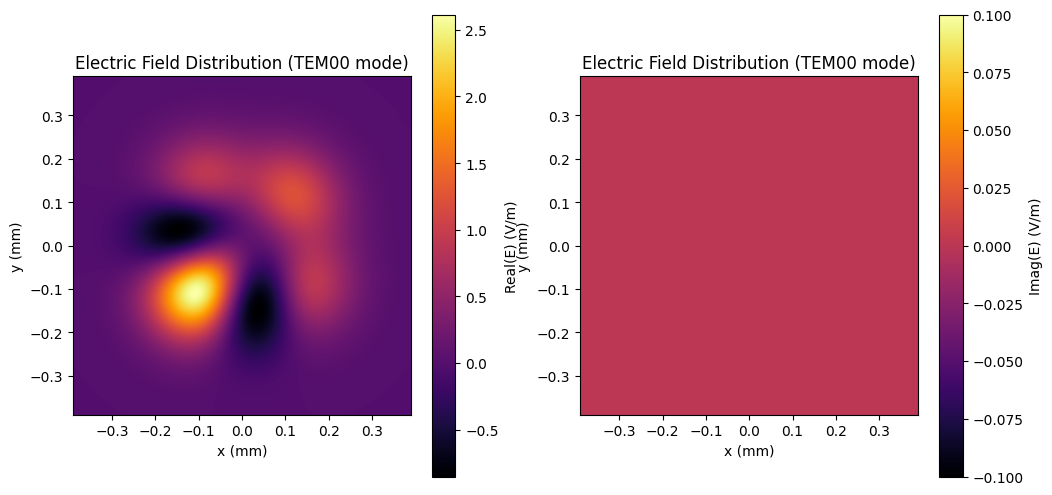

In [61]:
# visualize E_single (real and imaginary parts next to each other)
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(np.real(E_fun), extent=(-3*w_0*1e3, 3*w_0*1e3, -3*w_0*1e3, 3*w_0*1e3), cmap='inferno')

plt.colorbar(label='Real(E) (V/m)')
plt.title('Electric Field Distribution (TEM00 mode)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(np.imag(E_fun), extent=(-3*w_0*1e3, 3*w_0*1e3, -3*w_0*1e3, 3*w_0*1e3), cmap='inferno')
plt.colorbar(label='Imag(E) (V/m)')
plt.title('Electric Field Distribution (TEM00 mode)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.grid(False)

plt.show()

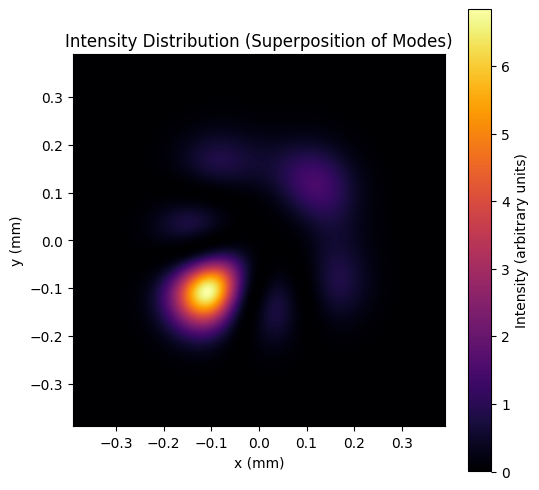

In [62]:
I_fun = np.abs(E_fun)**2

# visualize I_fun
plt.figure(figsize=(6,6))
plt.imshow(I_fun, extent=(-3*w_0*1e3, 3*w_0*1e3, -3*w_0*1e3, 3*w_0*1e3), cmap='inferno')
plt.colorbar(label='Intensity (arbitrary units)')
plt.title('Intensity Distribution (Superposition of Modes)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.grid(False)
plt.show()

Goal is to develop an algorithm that calculates the coefficients for an orthonormal basis (Hermite-Gauss modes are orthonormal) to recreate $E_\text{fun}$ using the inner product rule:

$$E_\text{fun}(x, y, z) = \sum_l^\infty \sum_m^\infty c_{l, m} E_{l, m}(x, y, z)$$

where 

$$c_{l, m} = \langle E_\text{fun}, E_{l, m} \rangle = \int \int E_\text{fun}, E_{l, m}^* dx dy$$

where the * represents the complex conjugate.

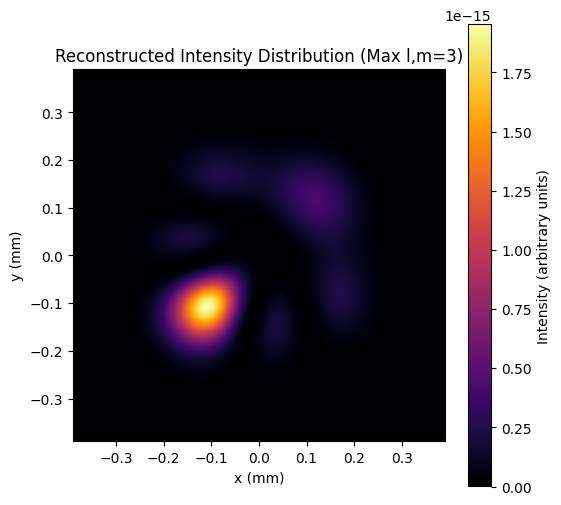

In [63]:
def calculate_mode_coefficients(E_field, X, Y, z, max_l, max_m):
    coefficients = {}
    dx = X[0,1] - X[0,0]  
    dy = Y[1,0] - Y[0,0]
    
    for l in range(max_l):
        for m in range(max_m):
            E_mode = E(X, Y, z, l, m)
            
            integrand = E_field * np.conj(E_mode)
            c_lm = np.sum(integrand) * dx * dy
            
            coefficients[(l,m)] = c_lm
    
    return coefficients

# build superposition matrix for max_l and max_m = 3

max_l = 4
max_m = 4   

mode_coeffs = calculate_mode_coefficients(E_fun, X, Y, z, max_l, max_m)

modes_reconstructed = [(l, m, mode_coeffs[(l,m)]) for l in range(max_l) for m in range(max_m)]

E_reconstructed = superposition(X, Y, z, modes_reconstructed)
I_reconstructed = np.abs(E_reconstructed)**2
# visualize I_reconstructed

plt.figure(figsize=(6,6))
plt.imshow(I_reconstructed, extent=(-3*w_0*1e3, 3*w_0*1e3, -3*w_0*1e3, 3*w_0*1e3), cmap='inferno')
plt.colorbar(label='Intensity (arbitrary units)')
plt.title('Reconstructed Intensity Distribution (Max l,m=3)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')        
plt.grid(False)
plt.show()

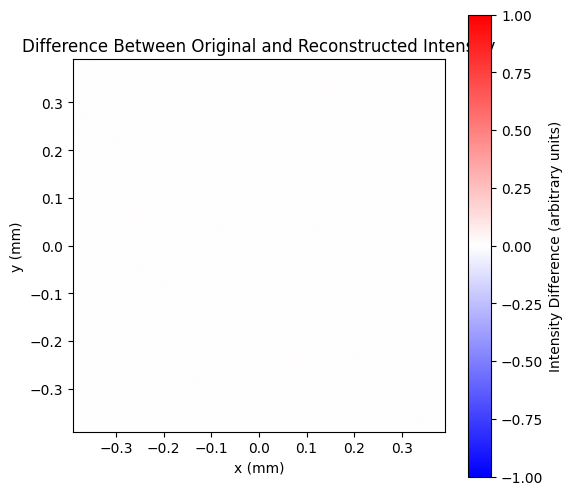

In [64]:

# normalize both to max of 1
I_fun /= np.max(I_fun)
I_reconstructed /= np.max(I_reconstructed)

plt.figure(figsize=(6,6))
plt.imshow(I_fun - I_reconstructed, extent=(-3*w_0*1e3, 3*w_0*1e3, -3*w_0*1e3, 3*w_0*1e3), cmap='bwr', vmin=-np.max(I_fun), vmax=np.max(I_fun))
plt.colorbar(label='Intensity Difference (arbitrary units)')
plt.title('Difference Between Original and Reconstructed Intensity')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')    
plt.grid(False)
plt.show()


In [66]:
# MSE between I_fun and I_reconstructed
mse = np.mean((I_fun - I_reconstructed)**2)
mse

np.float64(1.787542497912638e-13)